# LME銅先物 隣月間スプレッド 相関・共和分分析

## 概要
このノートブックでは、隣月間スプレッド（M1-M2、M2-M3、M3-M4）の相関関係と共和分関係を詳細に分析します。

### 分析目標
- スプレッド間の相関構造の理解
- 共和分関係（長期均衡関係）の検出
- ペアトレードの機会特定
- リスク分散効果の評価

### 期待される成果
- スプレッド間の相関パターンとその時間変動
- 共和分関係による長期均衡メカニズムの発見
- 統計的裁定機会の特定
- ポートフォリオ構築への示唆

In [1]:
# 必要ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from sqlalchemy import create_engine
import warnings
from datetime import datetime, timedelta
# import plotly.graph_objects as go
# import plotly.express as px
# from plotly.subplots import make_subplots
# Plotly replaced with matplotlib for compatibility
from scipy import stats
import os

# 統計・時系列分析 - 問題のある関数を個別にインポート
try:
    from statsmodels.tsa.stattools import coint, adfuller
    from statsmodels.stats.diagnostic import acorr_ljungbox
    from statsmodels.tsa.vector_ar.vecm import coint_johansen
    from statsmodels.regression.linear_model import OLS
    # statsmodels.apiの代わりに、必要な関数のみインポート
    from statsmodels.tools import add_constant
    print("✅ Statsmodels インポート成功")
except ImportError as e:
    print(f"⚠️ Statsmodels インポートエラー: {e}")
    print("一部の高度な統計分析機能が制限されます")
    # 基本的な代替関数を定義
    from scipy.stats import linregress
    def add_constant(x):
        """statsmodels.add_constantの代替"""
        return np.column_stack([np.ones(len(x)), x])

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

✅ Statsmodels インポート成功


In [2]:
# データベース接続とデータ取得
def get_db_connection():
    """PostgreSQLデータベースへの接続を取得"""
    try:
        engine = create_engine('postgresql://Yusuke@localhost:5432/lme_copper_db')
        return engine
    except Exception as e:
        print(f"データベース接続エラー: {e}")
        return None

def load_and_calculate_spreads():
    """スプレッドデータの取得と計算"""
    engine = get_db_connection()
    
    query = """
    SELECT 
        trade_date,
        contract_month,
        close_price,
        volume,
        open_interest
    FROM lme_copper_futures 
    WHERE contract_month IN (1, 2, 3, 4)
        AND close_price IS NOT NULL
        AND close_price > 0
    ORDER BY trade_date, contract_month
    """
    
    df = pd.read_sql(query, engine)
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    
    # ピボットしてスプレッド計算
    pivot_df = df.pivot(index='trade_date', columns='contract_month', values='close_price')
    pivot_df.columns = [f'M{int(col)}' for col in pivot_df.columns]
    
    # スプレッド計算
    spreads_df = pd.DataFrame(index=pivot_df.index)
    spreads_df['M1_M2_spread'] = pivot_df['M1'] - pivot_df['M2']
    spreads_df['M2_M3_spread'] = pivot_df['M2'] - pivot_df['M3']
    spreads_df['M3_M4_spread'] = pivot_df['M3'] - pivot_df['M4']
    
    # 価格データも保持
    spreads_df['M1_price'] = pivot_df['M1']
    spreads_df['M2_price'] = pivot_df['M2']
    spreads_df['M3_price'] = pivot_df['M3']
    spreads_df['M4_price'] = pivot_df['M4']
    
    return spreads_df.dropna()

# データ取得
spreads_data = load_and_calculate_spreads()
print(f"✅ データ取得完了: {len(spreads_data):,} レコード")
print(f"📅 分析期間: {spreads_data.index.min()} ～ {spreads_data.index.max()}")

✅ データ取得完了: 1,202 レコード
📅 分析期間: 2020-07-06 00:00:00 ～ 2025-07-04 00:00:00


## 1. 基本相関分析

📊 隣月間スプレッド相関行列:
              M1_M2_spread  M2_M3_spread  M3_M4_spread
M1_M2_spread        1.0000        0.6529        0.5993
M2_M3_spread        0.6529        1.0000        0.9538
M3_M4_spread        0.5993        0.9538        1.0000

📈 Spearman順位相関行列:
              M1_M2_spread  M2_M3_spread  M3_M4_spread
M1_M2_spread        1.0000        0.9379        0.9036
M2_M3_spread        0.9379        1.0000        0.9649
M3_M4_spread        0.9036        0.9649        1.0000


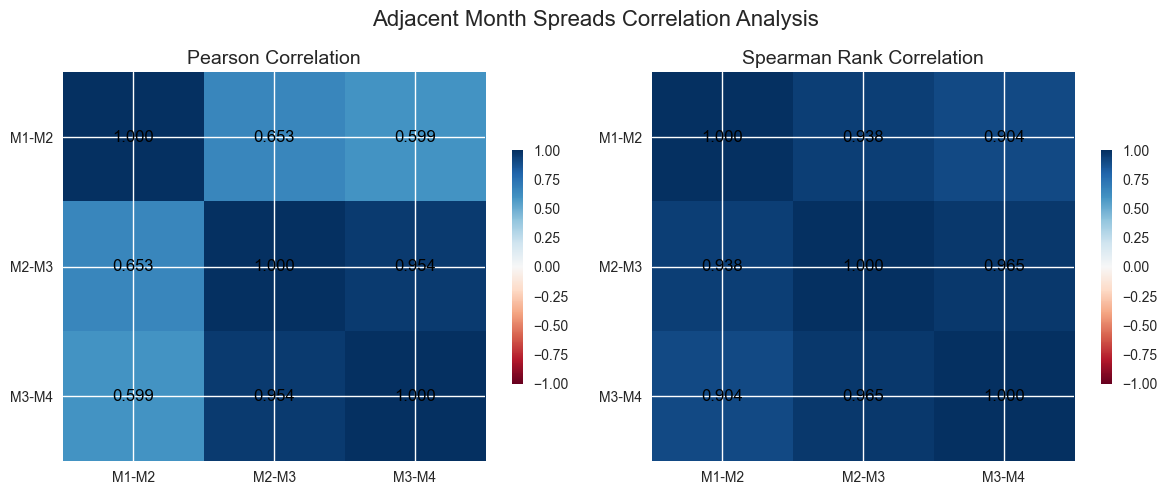

In [3]:
def analyze_basic_correlations(df):
    """基本相関分析"""
    spread_columns = ['M1_M2_spread', 'M2_M3_spread', 'M3_M4_spread']
    
    # 相関行列計算
    correlation_matrix = df[spread_columns].corr()
    
    print("📊 隣月間スプレッド相関行列:")
    print("=" * 40)
    print(correlation_matrix.round(4))
    
    # Spearman順位相関も計算
    spearman_corr = df[spread_columns].corr(method='spearman')
    
    print("\n📈 Spearman順位相関行列:")
    print("=" * 40)
    print(spearman_corr.round(4))
    
    return correlation_matrix, spearman_corr

def plot_correlation_heatmap(corr_matrix, spearman_corr):
    """相関ヒートマップの作成（matplotlib版）"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    spread_names = ['M1-M2', 'M2-M3', 'M3-M4']
    
    # Pearson相関ヒートマップ
    im1 = ax1.imshow(corr_matrix.values, cmap='RdBu', vmin=-1, vmax=1, aspect='auto')
    ax1.set_xticks(range(len(spread_names)))
    ax1.set_yticks(range(len(spread_names)))
    ax1.set_xticklabels(spread_names)
    ax1.set_yticklabels(spread_names)
    ax1.set_title('Pearson Correlation', fontsize=14)
    
    # 数値をセルに表示
    for i in range(len(spread_names)):
        for j in range(len(spread_names)):
            ax1.text(j, i, f'{corr_matrix.iloc[i, j]:.3f}', 
                    ha='center', va='center', color='black', fontsize=12)
    
    # Spearman相関ヒートマップ
    im2 = ax2.imshow(spearman_corr.values, cmap='RdBu', vmin=-1, vmax=1, aspect='auto')
    ax2.set_xticks(range(len(spread_names)))
    ax2.set_yticks(range(len(spread_names)))
    ax2.set_xticklabels(spread_names)
    ax2.set_yticklabels(spread_names)
    ax2.set_title('Spearman Rank Correlation', fontsize=14)
    
    # 数値をセルに表示
    for i in range(len(spread_names)):
        for j in range(len(spread_names)):
            ax2.text(j, i, f'{spearman_corr.iloc[i, j]:.3f}', 
                    ha='center', va='center', color='black', fontsize=12)
    
    # カラーバー追加
    plt.colorbar(im1, ax=ax1, shrink=0.6)
    plt.colorbar(im2, ax=ax2, shrink=0.6)
    
    plt.suptitle('Adjacent Month Spreads Correlation Analysis', fontsize=16)
    plt.tight_layout()
    
    return fig

# 基本相関分析実行
pearson_corr, spearman_corr = analyze_basic_correlations(spreads_data)

# 相関ヒートマップ表示
corr_chart = plot_correlation_heatmap(pearson_corr, spearman_corr)
plt.show()

# 画像保存
os.makedirs('../../generated_images', exist_ok=True)
corr_chart.savefig('../../generated_images/adjacent_spreads_correlation_heatmap.png', 
                   dpi=300, bbox_inches='tight')
plt.close()

## 2. 時間変動相関分析

📈 ローリング相関統計（60日窓）:
       M1M2_vs_M2M3  M2M3_vs_M3M4  M1M2_vs_M3M4
count     1143.0000     1143.0000     1143.0000
mean         0.7189        0.7333        0.5954
std          0.1761        0.3246        0.2273
min         -0.1378       -0.5581       -0.2126
25%          0.6260        0.7122        0.4521
50%          0.7575        0.8677        0.6434
75%          0.8517        0.9124        0.7700
max          0.9727        0.9785        0.9654


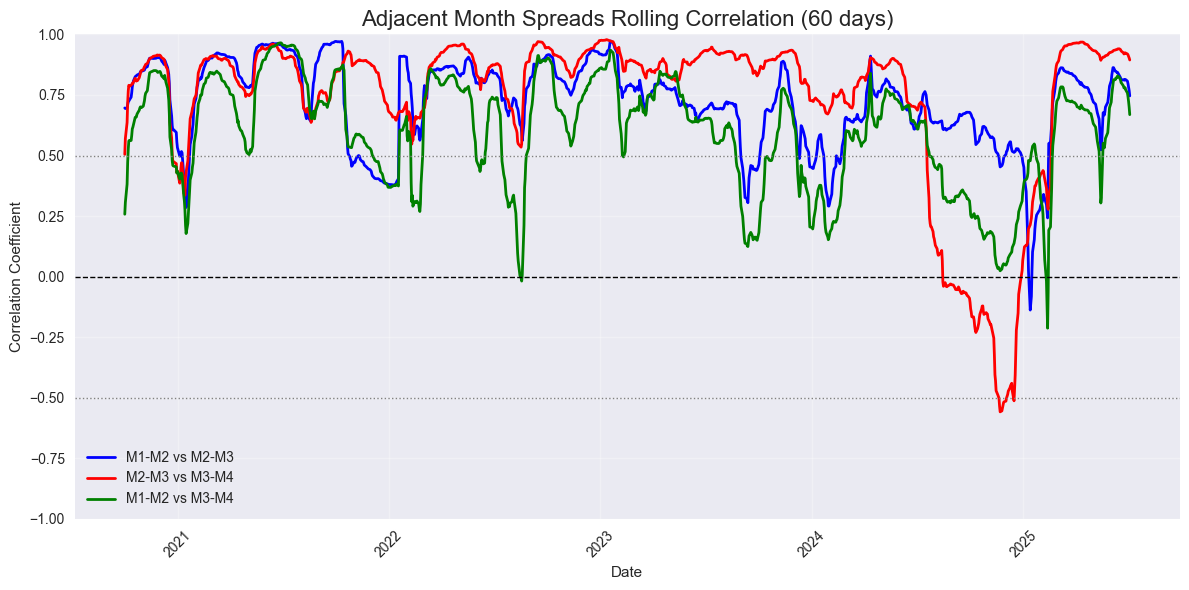

In [4]:
def calculate_rolling_correlations(df, window=60):
    """ローリング相関の計算"""
    rolling_corr_df = pd.DataFrame(index=df.index)
    
    # M1-M2 vs M2-M3の相関
    rolling_corr_df['M1M2_vs_M2M3'] = df['M1_M2_spread'].rolling(window=window).corr(
        df['M2_M3_spread']
    )
    
    # M2-M3 vs M3-M4の相関
    rolling_corr_df['M2M3_vs_M3M4'] = df['M2_M3_spread'].rolling(window=window).corr(
        df['M3_M4_spread']
    )
    
    # M1-M2 vs M3-M4の相関
    rolling_corr_df['M1M2_vs_M3M4'] = df['M1_M2_spread'].rolling(window=window).corr(
        df['M3_M4_spread']
    )
    
    return rolling_corr_df.dropna()

def plot_rolling_correlations(rolling_corr_df):
    """ローリング相関のプロット（matplotlib版）"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    correlations = [
        ('M1M2_vs_M2M3', 'M1-M2 vs M2-M3', 'blue'),
        ('M2M3_vs_M3M4', 'M2-M3 vs M3-M4', 'red'),
        ('M1M2_vs_M3M4', 'M1-M2 vs M3-M4', 'green')
    ]
    
    for col, name, color in correlations:
        ax.plot(rolling_corr_df.index, rolling_corr_df[col], 
               label=name, color=color, linewidth=2)
    
    # 基準線を追加
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.axhline(y=0.5, linestyle=':', color='gray', linewidth=1)
    ax.axhline(y=-0.5, linestyle=':', color='gray', linewidth=1)
    
    ax.set_title('Adjacent Month Spreads Rolling Correlation (60 days)', fontsize=16)
    ax.set_xlabel('Date')
    ax.set_ylabel('Correlation Coefficient')
    ax.set_ylim(-1, 1)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig

# ローリング相関計算
rolling_corr_data = calculate_rolling_correlations(spreads_data, window=60)

print(f"📈 ローリング相関統計（60日窓）:")
print("=" * 50)
print(rolling_corr_data.describe().round(4))

# ローリング相関チャート
rolling_corr_chart = plot_rolling_correlations(rolling_corr_data)
plt.show()

# 画像保存
rolling_corr_chart.savefig('../../generated_images/adjacent_spreads_rolling_correlation.png', 
                           dpi=300, bbox_inches='tight')
plt.close()

## 3. 共和分分析（長期均衡関係）

In [5]:
def test_cointegration(df):
    """共和分検定の実行"""
    spread_columns = ['M1_M2_spread', 'M2_M3_spread', 'M3_M4_spread']
    spread_names = ['M1-M2', 'M2-M3', 'M3-M4']
    
    print("🔬 共和分検定結果:")
    print("=" * 60)
    
    coint_results = {}
    
    # ペアワイズ共和分検定
    pairs = [
        (('M1_M2_spread', 'M2_M3_spread'), ('M1-M2', 'M2-M3')),
        (('M2_M3_spread', 'M3_M4_spread'), ('M2-M3', 'M3-M4')),
        (('M1_M2_spread', 'M3_M4_spread'), ('M1-M2', 'M3-M4'))
    ]
    
    for (col1, col2), (name1, name2) in pairs:
        # Engle-Granger共和分検定
        coint_t, p_value, critical_values = coint(df[col1], df[col2])
        
        coint_results[f'{name1}_vs_{name2}'] = {
            'test_statistic': coint_t,
            'p_value': p_value,
            'critical_values': critical_values
        }
        
        print(f"\n{name1} vs {name2}:")
        print(f"  検定統計量: {coint_t:.4f}")
        print(f"  p値: {p_value:.4f}")
        print(f"  結果: {'共和分関係あり' if p_value < 0.05 else '共和分関係なし'}")
        print(f"  臨界値 1%: {critical_values[0]:.4f}")
        print(f"  臨界値 5%: {critical_values[1]:.4f}")
        print(f"  臨界値 10%: {critical_values[2]:.4f}")
    
    return coint_results

def johansen_cointegration_test(df):
    """Johansen共和分検定（多変量）"""
    spread_data = df[['M1_M2_spread', 'M2_M3_spread', 'M3_M4_spread']].dropna()
    
    print(f"\n🔍 Johansen共和分検定（多変量）:")
    print("=" * 60)
    
    # Johansen検定実行
    johansen_result = coint_johansen(spread_data, det_order=0, k_ar_diff=1)
    
    print(f"Trace統計量:")
    for i, (trace_stat, cv_90, cv_95, cv_99) in enumerate(
        zip(johansen_result.lr1, johansen_result.cvt[:, 0], 
            johansen_result.cvt[:, 1], johansen_result.cvt[:, 2])
    ):
        print(f"  r≤{i}: {trace_stat:.4f} (90%: {cv_90:.4f}, 95%: {cv_95:.4f}, 99%: {cv_99:.4f})")
        
        if trace_stat > cv_95:
            print(f"    → r>{i}の共和分関係あり（95%水準）")
        else:
            print(f"    → r≤{i}の共和分関係")
    
    print(f"\nMaximum Eigenvalue統計量:")
    for i, (max_stat, cv_90, cv_95, cv_99) in enumerate(
        zip(johansen_result.lr2, johansen_result.cvm[:, 0], 
            johansen_result.cvm[:, 1], johansen_result.cvm[:, 2])
    ):
        print(f"  r={i}: {max_stat:.4f} (90%: {cv_90:.4f}, 95%: {cv_95:.4f}, 99%: {cv_99:.4f})")
    
    return johansen_result

# 共和分検定実行
coint_results = test_cointegration(spreads_data)
johansen_result = johansen_cointegration_test(spreads_data)

🔬 共和分検定結果:

M1-M2 vs M2-M3:
  検定統計量: -5.3950
  p値: 0.0000
  結果: 共和分関係あり
  臨界値 1%: -3.9056
  臨界値 5%: -3.3412
  臨界値 10%: -3.0480

M2-M3 vs M3-M4:
  検定統計量: -7.4751
  p値: 0.0000
  結果: 共和分関係あり
  臨界値 1%: -3.9056
  臨界値 5%: -3.3412
  臨界値 10%: -3.0480

M1-M2 vs M3-M4:
  検定統計量: -6.0914
  p値: 0.0000
  結果: 共和分関係あり
  臨界値 1%: -3.9056
  臨界値 5%: -3.3412
  臨界値 10%: -3.0480

🔍 Johansen共和分検定（多変量）:
Trace統計量:
  r≤0: 394.2188 (90%: 27.0669, 95%: 29.7961, 99%: 35.4628)
    → r>0の共和分関係あり（95%水準）
  r≤1: 74.3512 (90%: 13.4294, 95%: 15.4943, 99%: 19.9349)
    → r>1の共和分関係あり（95%水準）
  r≤2: 7.3045 (90%: 2.7055, 95%: 3.8415, 99%: 6.6349)
    → r>2の共和分関係あり（95%水準）

Maximum Eigenvalue統計量:
  r=0: 319.8676 (90%: 18.8928, 95%: 21.1314, 99%: 25.8650)
  r=1: 67.0467 (90%: 12.2971, 95%: 14.2639, 99%: 18.5200)
  r=2: 7.3045 (90%: 2.7055, 95%: 3.8415, 99%: 6.6349)


In [6]:
def analyze_cointegration_relationships(df, coint_results):
    """共和分関係の詳細分析"""
    
    print(f"\n📊 共和分関係の詳細分析:")
    print("=" * 60)
    
    # 有意な共和分関係を持つペアを特定
    significant_pairs = []
    
    for pair_name, result in coint_results.items():
        if result['p_value'] < 0.05:
            significant_pairs.append(pair_name)
            print(f"✅ {pair_name}: 共和分関係あり（p={result['p_value']:.4f}）")
    
    if not significant_pairs:
        print("❌ 有意な共和分関係は検出されませんでした")
        return None
    
    # 最も強い共和分関係のペアで詳細分析
    best_pair_name = min(coint_results.keys(), key=lambda x: coint_results[x]['p_value'])
    print(f"\n🎯 最強共和分関係: {best_pair_name}")
    
    # ペア名から実際のカラム名を特定
    if 'M1-M2_vs_M2-M3' in best_pair_name:
        col1, col2 = 'M1_M2_spread', 'M2_M3_spread'
        name1, name2 = 'M1-M2', 'M2-M3'
    elif 'M2-M3_vs_M3-M4' in best_pair_name:
        col1, col2 = 'M2_M3_spread', 'M3_M4_spread'
        name1, name2 = 'M2-M3', 'M3-M4'
    else:
        col1, col2 = 'M1_M2_spread', 'M3_M4_spread'
        name1, name2 = 'M1-M2', 'M3-M4'
    
    try:
        # 共和分回帰
        y = df[col1]
        x = add_constant(df[col2])
        
        model = OLS(y, x).fit()
        
        print(f"\n回帰式: {name1} = {model.params[0]:.4f} + {model.params[1]:.4f} * {name2}")
        print(f"R²: {model.rsquared:.4f}")
        print(f"回帰係数のt値: {model.tvalues[1]:.4f}")
        
        # 残差（誤差修正項）の計算
        residuals = model.resid
        
        # 残差の定常性検定
        adf_stat, adf_p, _, _, adf_crit, _ = adfuller(residuals)
        
        print(f"\n残差の定常性検定（ADF）:")
        print(f"  統計量: {adf_stat:.4f}")
        print(f"  p値: {adf_p:.4f}")
        print(f"  結果: {'定常' if adf_p < 0.05 else '非定常'}")
        
        return {
            'best_pair': (col1, col2),
            'regression_model': model,
            'residuals': residuals,
            'adf_test': (adf_stat, adf_p)
        }
        
    except Exception as e:
        print(f"⚠️ 共和分回帰分析でエラー: {e}")
        print("scipy.statsを使用した簡易回帰分析に切り替えます")
        
        # 代替分析（scipyを使用）
        from scipy.stats import linregress
        
        slope, intercept, r_value, p_value, std_err = linregress(df[col2], df[col1])
        
        print(f"\n回帰式: {name1} = {intercept:.4f} + {slope:.4f} * {name2}")
        print(f"R²: {r_value**2:.4f}")
        print(f"p値: {p_value:.4f}")
        
        # 残差計算
        predicted = intercept + slope * df[col2]
        residuals = df[col1] - predicted
        
        # 残差の定常性検定
        adf_stat, adf_p, _, _, adf_crit, _ = adfuller(residuals)
        
        print(f"\n残差の定常性検定（ADF）:")
        print(f"  統計量: {adf_stat:.4f}")
        print(f"  p値: {adf_p:.4f}")
        print(f"  結果: {'定常' if adf_p < 0.05 else '非定常'}")
        
        # 簡易モデルオブジェクト作成
        class SimpleModel:
            def __init__(self, intercept, slope, r_squared):
                self.params = [intercept, slope]
                self.rsquared = r_squared
        
        model = SimpleModel(intercept, slope, r_value**2)
        
        return {
            'best_pair': (col1, col2),
            'regression_model': model,
            'residuals': residuals,
            'adf_test': (adf_stat, adf_p)
        }

# 共和分関係の詳細分析
coint_analysis = analyze_cointegration_relationships(spreads_data, coint_results)


📊 共和分関係の詳細分析:
✅ M1-M2_vs_M2-M3: 共和分関係あり（p=0.0000）
✅ M2-M3_vs_M3-M4: 共和分関係あり（p=0.0000）
✅ M1-M2_vs_M3-M4: 共和分関係あり（p=0.0000）

🎯 最強共和分関係: M2-M3_vs_M3-M4

回帰式: M2-M3 = 0.1917 + 1.1428 * M3-M4
R²: 0.9096
回帰係数のt値: 109.9117

残差の定常性検定（ADF）:
  統計量: -7.4718
  p値: 0.0000
  結果: 定常


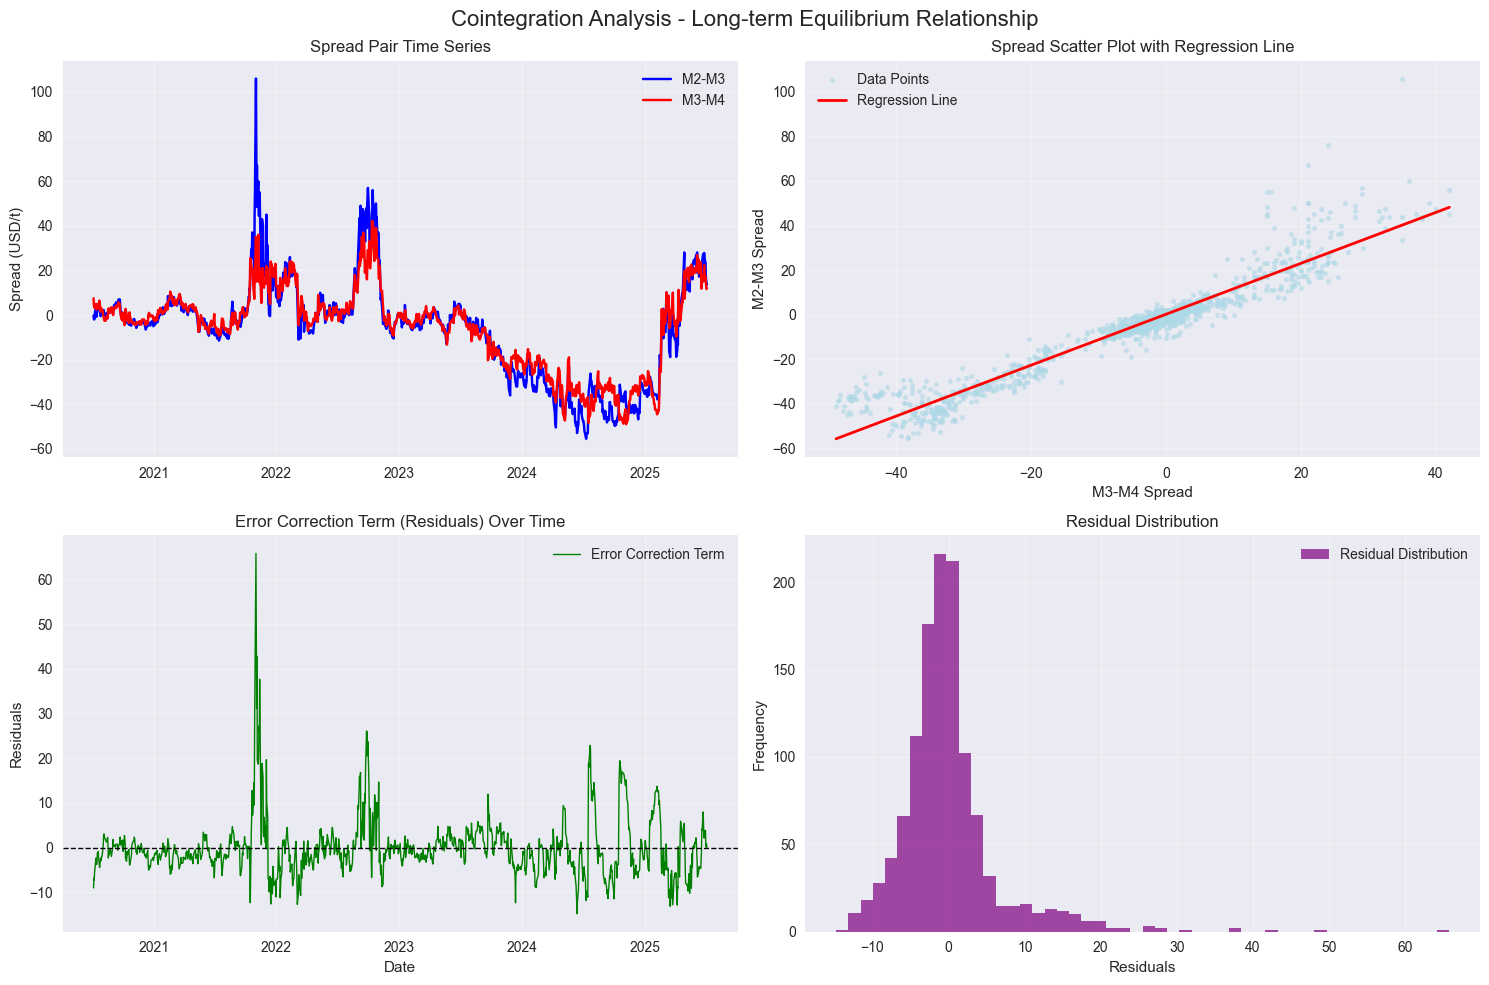

In [7]:
def plot_cointegration_analysis(df, coint_analysis):
    """共和分分析の可視化（matplotlib版）"""
    if coint_analysis is None:
        print("共和分関係が検出されなかったため、プロットをスキップします")
        return None
    
    col1, col2 = coint_analysis['best_pair']
    residuals = coint_analysis['residuals']
    model = coint_analysis['regression_model']
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. 時系列プロット
    ax1.plot(df.index, df[col1], label=col1.replace('_spread', '').replace('_', '-'), color='blue')
    ax1.plot(df.index, df[col2], label=col2.replace('_spread', '').replace('_', '-'), color='red')
    ax1.set_title('Spread Pair Time Series')
    ax1.set_ylabel('Spread (USD/t)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 散布図と回帰線
    ax2.scatter(df[col2], df[col1], alpha=0.6, s=10, color='lightblue', label='Data Points')
    
    # 回帰線
    x_range = np.linspace(df[col2].min(), df[col2].max(), 100)
    y_pred = model.params[0] + model.params[1] * x_range
    ax2.plot(x_range, y_pred, color='red', linewidth=2, label='Regression Line')
    
    ax2.set_title('Spread Scatter Plot with Regression Line')
    ax2.set_xlabel(f"{col2.replace('_spread', '').replace('_', '-')} Spread")
    ax2.set_ylabel(f"{col1.replace('_spread', '').replace('_', '-')} Spread")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. 残差の時系列
    ax3.plot(df.index, residuals, color='green', linewidth=1, label='Error Correction Term')
    ax3.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax3.set_title('Error Correction Term (Residuals) Over Time')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Residuals')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. 残差のヒストグラム
    ax4.hist(residuals, bins=50, alpha=0.7, color='purple', label='Residual Distribution')
    ax4.set_title('Residual Distribution')
    ax4.set_xlabel('Residuals')
    ax4.set_ylabel('Frequency')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Cointegration Analysis - Long-term Equilibrium Relationship', fontsize=16)
    plt.tight_layout()
    
    return fig

# 共和分分析の可視化
if coint_analysis:
    coint_chart = plot_cointegration_analysis(spreads_data, coint_analysis)
    if coint_chart:
        plt.show()
        
        # 画像保存
        coint_chart.savefig('../../generated_images/adjacent_spreads_cointegration_analysis.png', 
                           dpi=300, bbox_inches='tight')
        plt.close()

## 4. 主成分分析（PCA）

📊 主成分分析結果:
PC1: 寄与率 0.8276 (82.76%), 累積寄与率 0.8276 (82.76%)
PC2: 寄与率 0.1579 (15.79%), 累積寄与率 0.9855 (98.55%)
PC3: 寄与率 0.0145 (1.45%), 累積寄与率 1.0000 (100.00%)

📈 主成分負荷量:
          PC1     PC2     PC3
M1-M2  0.8084  0.5891 -0.0145
M2-M3  0.9657 -0.2123  0.1521
M3-M4  0.9480 -0.2861 -0.1426


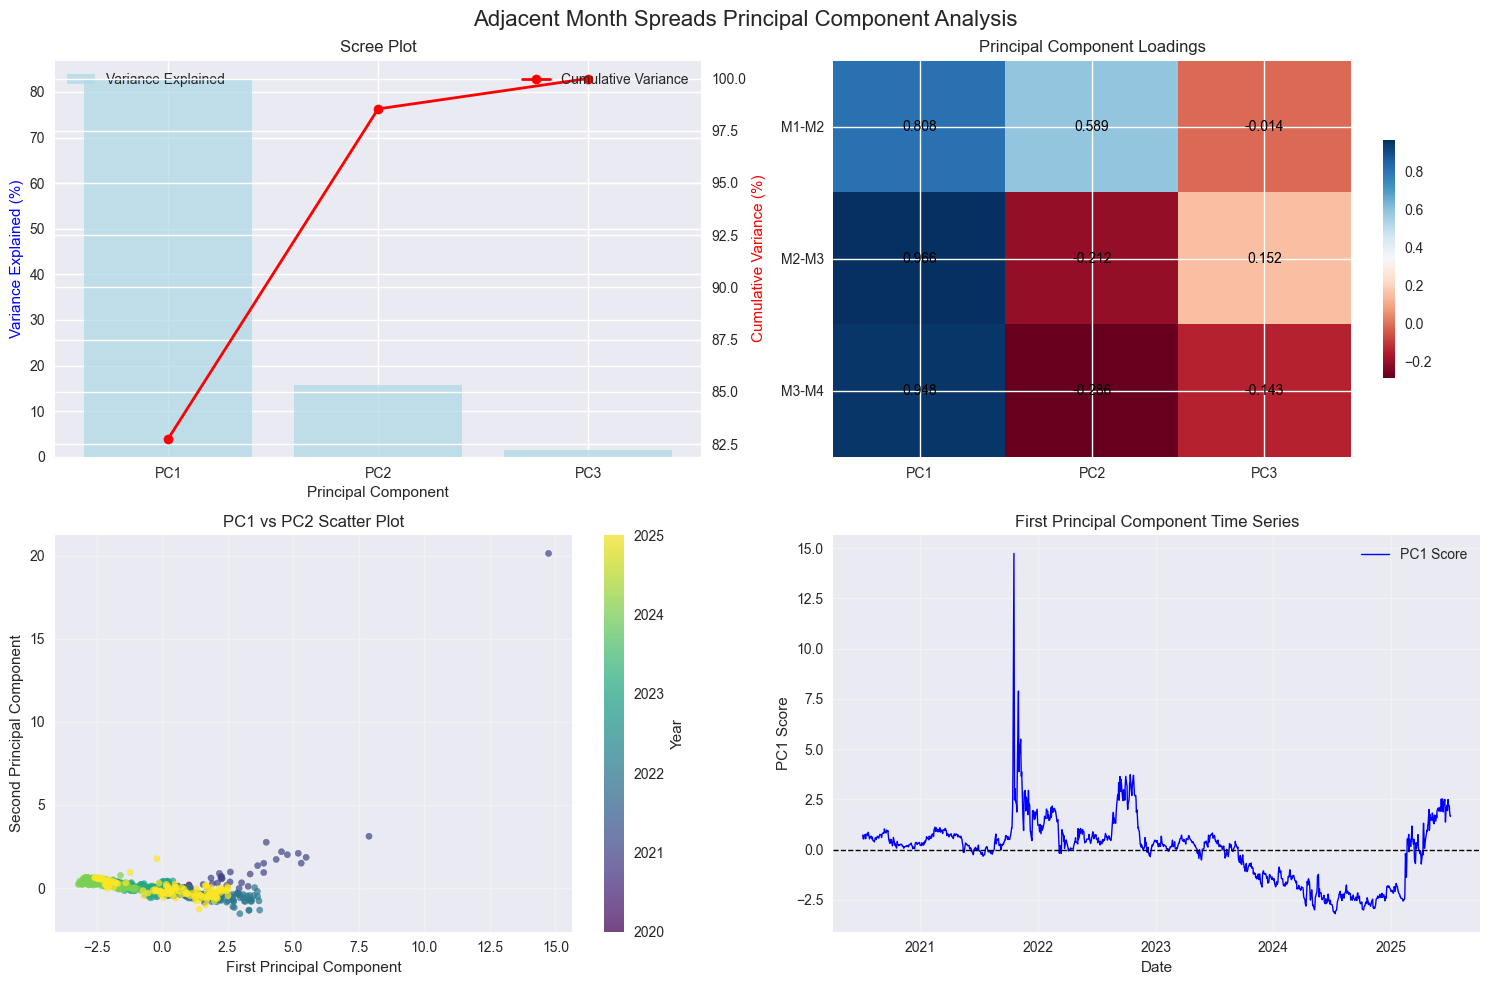

In [8]:
def perform_pca_analysis(df):
    """主成分分析の実行"""
    spread_columns = ['M1_M2_spread', 'M2_M3_spread', 'M3_M4_spread']
    spread_data = df[spread_columns].dropna()
    
    # データの標準化
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(spread_data)
    
    # PCA実行
    pca = PCA()
    pca_result = pca.fit_transform(scaled_data)
    
    print(f"📊 主成分分析結果:")
    print("=" * 50)
    
    # 寄与率と累積寄与率
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    for i, (var_ratio, cum_ratio) in enumerate(zip(explained_variance_ratio, cumulative_variance_ratio)):
        print(f"PC{i+1}: 寄与率 {var_ratio:.4f} ({var_ratio*100:.2f}%), 累積寄与率 {cum_ratio:.4f} ({cum_ratio*100:.2f}%)")
    
    # 主成分負荷量
    print(f"\n📈 主成分負荷量:")
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    loadings_df = pd.DataFrame(
        loadings,
        index=['M1-M2', 'M2-M3', 'M3-M4'],
        columns=[f'PC{i+1}' for i in range(len(spread_columns))]
    )
    
    print(loadings_df.round(4))
    
    # 主成分スコア
    pca_scores_df = pd.DataFrame(
        pca_result,
        index=spread_data.index,
        columns=[f'PC{i+1}' for i in range(len(spread_columns))]
    )
    
    return {
        'pca_model': pca,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance_ratio': cumulative_variance_ratio,
        'loadings': loadings_df,
        'scores': pca_scores_df,
        'scaler': scaler
    }

def plot_pca_analysis(pca_results):
    """PCA分析の可視化（matplotlib版）"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. スクリープロット
    pcs = [f'PC{i+1}' for i in range(len(pca_results['explained_variance_ratio']))]
    explained_var = pca_results['explained_variance_ratio'] * 100
    cumulative_var = pca_results['cumulative_variance_ratio'] * 100
    
    bars = ax1.bar(pcs, explained_var, color='lightblue', alpha=0.7, label='Variance Explained')
    ax1_twin = ax1.twinx()
    ax1_twin.plot(pcs, cumulative_var, color='red', marker='o', linewidth=2, label='Cumulative Variance')
    
    ax1.set_title('Scree Plot')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Variance Explained (%)', color='blue')
    ax1_twin.set_ylabel('Cumulative Variance (%)', color='red')
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    
    # 2. 主成分負荷量のヒートマップ
    im = ax2.imshow(pca_results['loadings'].values, cmap='RdBu', aspect='auto')
    ax2.set_xticks(range(len(pca_results['loadings'].columns)))
    ax2.set_yticks(range(len(pca_results['loadings'].index)))
    ax2.set_xticklabels(pca_results['loadings'].columns)
    ax2.set_yticklabels(pca_results['loadings'].index)
    ax2.set_title('Principal Component Loadings')
    
    # 数値をセルに表示
    for i in range(len(pca_results['loadings'].index)):
        for j in range(len(pca_results['loadings'].columns)):
            ax2.text(j, i, f'{pca_results["loadings"].iloc[i, j]:.3f}', 
                    ha='center', va='center', color='black', fontsize=10)
    
    plt.colorbar(im, ax=ax2, shrink=0.6)
    
    # 3. 主成分スコア散布図
    years = pca_results['scores'].index.year
    scatter = ax3.scatter(pca_results['scores']['PC1'], pca_results['scores']['PC2'], 
                         c=years, cmap='viridis', alpha=0.7, s=20)
    ax3.set_title('PC1 vs PC2 Scatter Plot')
    ax3.set_xlabel('First Principal Component')
    ax3.set_ylabel('Second Principal Component')
    plt.colorbar(scatter, ax=ax3, label='Year')
    ax3.grid(True, alpha=0.3)
    
    # 4. 第1主成分の時系列
    ax4.plot(pca_results['scores'].index, pca_results['scores']['PC1'], 
            color='blue', linewidth=1, label='PC1 Score')
    ax4.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax4.set_title('First Principal Component Time Series')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('PC1 Score')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Adjacent Month Spreads Principal Component Analysis', fontsize=16)
    plt.tight_layout()
    
    return fig

# PCA分析実行
pca_results = perform_pca_analysis(spreads_data)

# PCA可視化
pca_chart = plot_pca_analysis(pca_results)
plt.show()

# 画像保存
pca_chart.savefig('../../generated_images/adjacent_spreads_pca_analysis.png', 
                  dpi=300, bbox_inches='tight')
plt.close()

## 5. 統計的裁定機会の特定

In [9]:
def identify_statistical_arbitrage_opportunities(df, pca_results, coint_analysis):
    """統計的裁定機会の特定"""
    
    print(f"🎯 統計的裁定機会分析:")
    print("=" * 60)
    
    arbitrage_opportunities = {}
    
    # 1. 共和分ベースの裁定
    if coint_analysis and coint_analysis['adf_test'][1] < 0.05:
        residuals = coint_analysis['residuals']
        
        # 残差の統計量
        residual_mean = residuals.mean()
        residual_std = residuals.std()
        
        # エントリー・エグジットシグナル
        upper_threshold = residual_mean + 2 * residual_std
        lower_threshold = residual_mean - 2 * residual_std
        
        # シグナル生成
        signals = pd.Series(index=residuals.index, dtype=float)
        signals[residuals > upper_threshold] = -1  # ショートシグナル
        signals[residuals < lower_threshold] = 1   # ロングシグナル
        signals[abs(residuals - residual_mean) < 0.5 * residual_std] = 0  # エグジット
        
        # 前値で埋める（新しい方法）
        signals = signals.ffill().fillna(0)
        
        arbitrage_opportunities['cointegration_pairs_trading'] = {
            'pair': coint_analysis['best_pair'],
            'residuals': residuals,
            'signals': signals,
            'thresholds': (lower_threshold, upper_threshold),
            'signal_frequency': (signals != 0).sum() / len(signals) * 100
        }
        
        print(f"✅ 共和分ペアトレード機会:")
        print(f"   対象ペア: {coint_analysis['best_pair']}")
        print(f"   シグナル頻度: {arbitrage_opportunities['cointegration_pairs_trading']['signal_frequency']:.2f}%")
        print(f"   エントリー閾値: ±{2:.1f}σ ({lower_threshold:.4f}, {upper_threshold:.4f})")
    
    # 2. 主成分ベースの裁定
    pc1_scores = pca_results['scores']['PC1']
    pc1_mean = pc1_scores.mean()
    pc1_std = pc1_scores.std()
    
    # 第1主成分の極値検出
    pc1_upper = pc1_mean + 2 * pc1_std
    pc1_lower = pc1_mean - 2 * pc1_std
    
    pc1_signals = pd.Series(index=pc1_scores.index, dtype=float)
    pc1_signals[pc1_scores > pc1_upper] = -1
    pc1_signals[pc1_scores < pc1_lower] = 1
    pc1_signals[abs(pc1_scores - pc1_mean) < 0.5 * pc1_std] = 0
    pc1_signals = pc1_signals.ffill().fillna(0)
    
    arbitrage_opportunities['pca_factor_trading'] = {
        'pc1_scores': pc1_scores,
        'signals': pc1_signals,
        'thresholds': (pc1_lower, pc1_upper),
        'signal_frequency': (pc1_signals != 0).sum() / len(pc1_signals) * 100
    }
    
    print(f"\n✅ 主成分ファクター取引機会:")
    print(f"   第1主成分寄与率: {pca_results['explained_variance_ratio'][0]*100:.2f}%")
    print(f"   シグナル頻度: {arbitrage_opportunities['pca_factor_trading']['signal_frequency']:.2f}%")
    print(f"   エントリー閾値: ±{2:.1f}σ ({pc1_lower:.4f}, {pc1_upper:.4f})")
    
    # 3. 相関ブレイクダウン機会
    rolling_corr_60d = spreads_data['M1_M2_spread'].rolling(window=60).corr(
        spreads_data['M2_M3_spread']
    ).dropna()
    
    corr_mean = rolling_corr_60d.mean()
    corr_std = rolling_corr_60d.std()
    
    # 相関の異常値（ブレイクダウン）を検出
    corr_breakdown_threshold = corr_mean - 2 * corr_std
    correlation_breakdowns = rolling_corr_60d < corr_breakdown_threshold
    
    arbitrage_opportunities['correlation_breakdown'] = {
        'rolling_correlation': rolling_corr_60d,
        'breakdown_threshold': corr_breakdown_threshold,
        'breakdown_periods': correlation_breakdowns,
        'breakdown_frequency': correlation_breakdowns.sum() / len(correlation_breakdowns) * 100
    }
    
    print(f"\n✅ 相関ブレイクダウン機会:")
    print(f"   平均相関: {corr_mean:.4f}")
    print(f"   ブレイクダウン閾値: {corr_breakdown_threshold:.4f}")
    print(f"   ブレイクダウン頻度: {arbitrage_opportunities['correlation_breakdown']['breakdown_frequency']:.2f}%")
    
    return arbitrage_opportunities

# 統計的裁定機会の分析
arbitrage_opps = identify_statistical_arbitrage_opportunities(
    spreads_data, pca_results, coint_analysis
)

🎯 統計的裁定機会分析:
✅ 共和分ペアトレード機会:
   対象ペア: ('M2_M3_spread', 'M3_M4_spread')
   シグナル頻度: 10.57%
   エントリー閾値: ±2.0σ (-13.1089, 13.1089)

✅ 主成分ファクター取引機会:
   第1主成分寄与率: 82.76%
   シグナル頻度: 19.05%
   エントリー閾値: ±2.0σ (-3.1527, 3.1527)

✅ 相関ブレイクダウン機会:
   平均相関: 0.7189
   ブレイクダウン閾値: 0.3667
   ブレイクダウン頻度: 3.76%


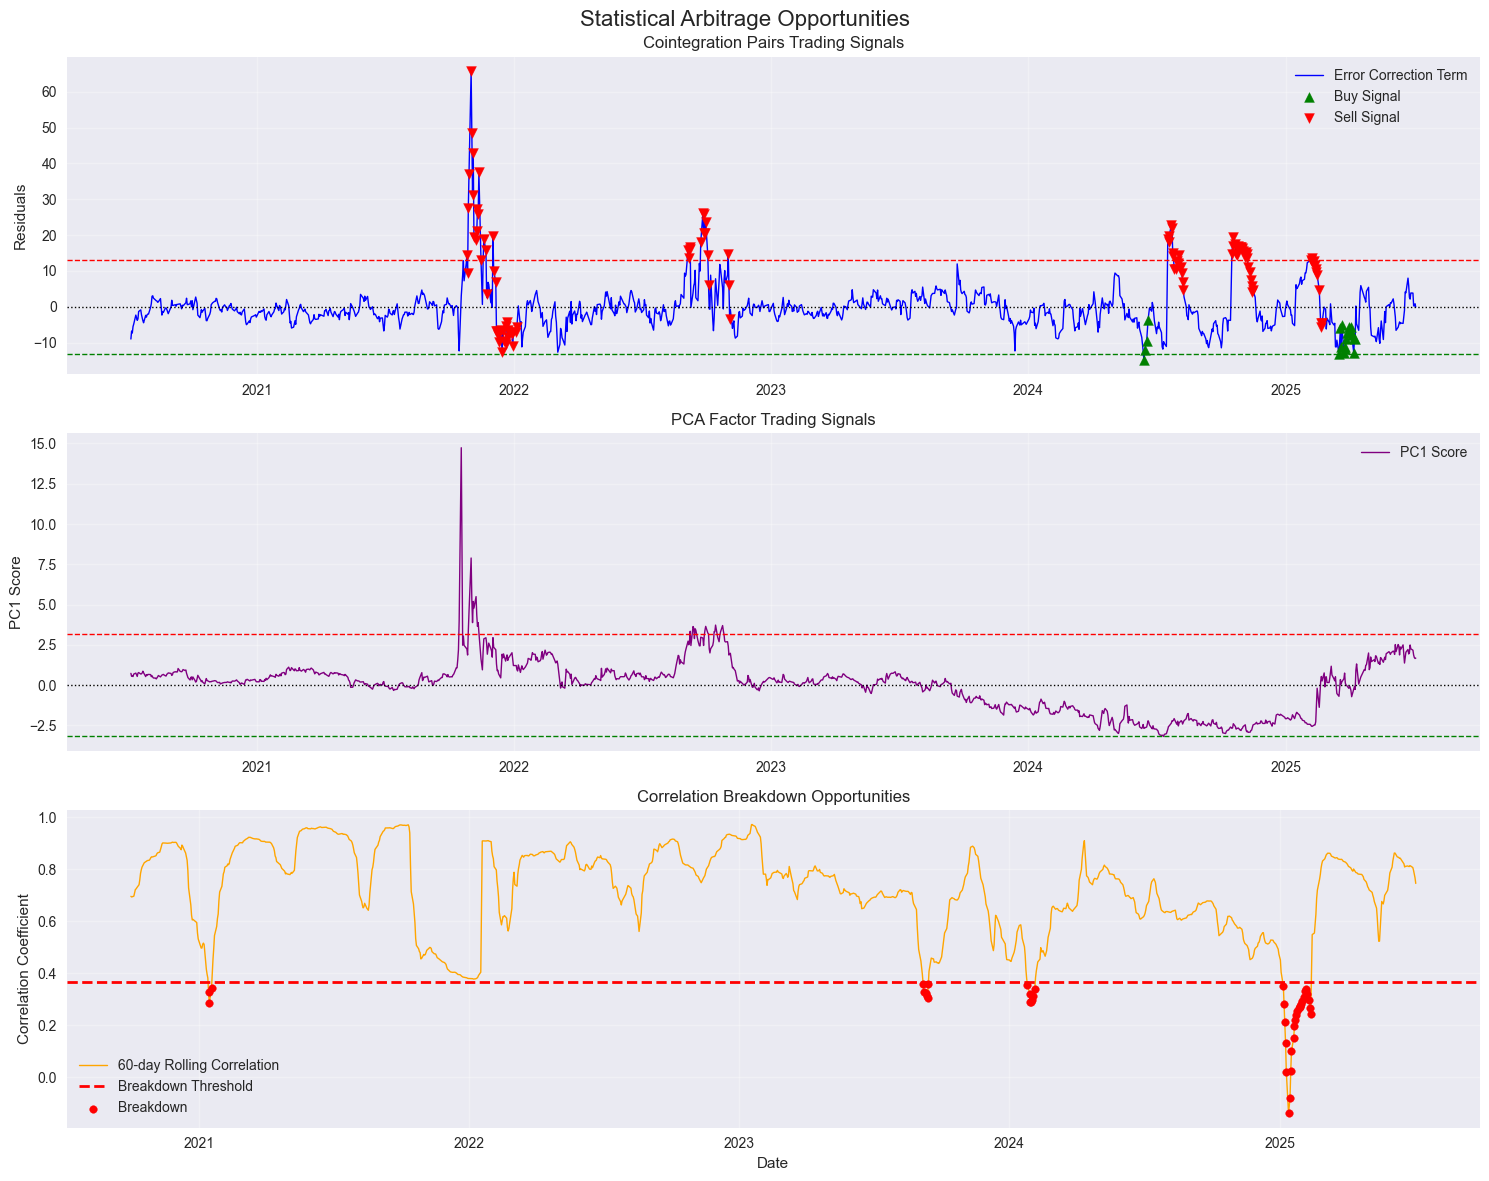

In [10]:
def plot_arbitrage_opportunities(arbitrage_opps):
    """統計的裁定機会の可視化（matplotlib版）"""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    
    # 1. 共和分ペアトレード
    if 'cointegration_pairs_trading' in arbitrage_opps:
        coint_data = arbitrage_opps['cointegration_pairs_trading']
        residuals = coint_data['residuals']
        signals = coint_data['signals']
        lower_thresh, upper_thresh = coint_data['thresholds']
        
        ax1.plot(residuals.index, residuals, color='blue', linewidth=1, label='Error Correction Term')
        
        # 閾値線
        ax1.axhline(y=upper_thresh, linestyle='--', color='red', linewidth=1)
        ax1.axhline(y=lower_thresh, linestyle='--', color='green', linewidth=1)
        ax1.axhline(y=0, linestyle=':', color='black', linewidth=1)
        
        # シグナルをハイライト
        buy_signals = signals[signals == 1]
        sell_signals = signals[signals == -1]
        
        if len(buy_signals) > 0:
            ax1.scatter(buy_signals.index, residuals.loc[buy_signals.index], 
                       color='green', marker='^', s=50, label='Buy Signal', zorder=5)
        
        if len(sell_signals) > 0:
            ax1.scatter(sell_signals.index, residuals.loc[sell_signals.index], 
                       color='red', marker='v', s=50, label='Sell Signal', zorder=5)
        
        ax1.set_title('Cointegration Pairs Trading Signals')
        ax1.set_ylabel('Residuals')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # 2. 主成分ファクター取引
    if 'pca_factor_trading' in arbitrage_opps:
        pca_data = arbitrage_opps['pca_factor_trading']
        pc1_scores = pca_data['pc1_scores']
        pc1_signals = pca_data['signals']
        pc1_lower, pc1_upper = pca_data['thresholds']
        
        ax2.plot(pc1_scores.index, pc1_scores, color='purple', linewidth=1, label='PC1 Score')
        
        # 閾値線
        ax2.axhline(y=pc1_upper, linestyle='--', color='red', linewidth=1)
        ax2.axhline(y=pc1_lower, linestyle='--', color='green', linewidth=1)
        ax2.axhline(y=0, linestyle=':', color='black', linewidth=1)
        
        ax2.set_title('PCA Factor Trading Signals')
        ax2.set_ylabel('PC1 Score')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 3. 相関ブレイクダウン
    if 'correlation_breakdown' in arbitrage_opps:
        corr_data = arbitrage_opps['correlation_breakdown']
        rolling_corr = corr_data['rolling_correlation']
        breakdown_threshold = corr_data['breakdown_threshold']
        breakdowns = corr_data['breakdown_periods']
        
        ax3.plot(rolling_corr.index, rolling_corr, color='orange', linewidth=1, label='60-day Rolling Correlation')
        
        # ブレイクダウン閾値
        ax3.axhline(y=breakdown_threshold, linestyle='--', color='red', linewidth=2, label='Breakdown Threshold')
        
        # ブレイクダウン期間をハイライト
        breakdown_dates = breakdowns[breakdowns].index
        if len(breakdown_dates) > 0:
            ax3.scatter(breakdown_dates, rolling_corr.loc[breakdown_dates], 
                       color='red', s=30, label='Breakdown', zorder=5)
        
        ax3.set_title('Correlation Breakdown Opportunities')
        ax3.set_ylabel('Correlation Coefficient')
        ax3.set_xlabel('Date')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    plt.suptitle('Statistical Arbitrage Opportunities', fontsize=16)
    plt.tight_layout()
    
    return fig

# 裁定機会の可視化
arbitrage_chart = plot_arbitrage_opportunities(arbitrage_opps)
plt.show()

# 画像保存
arbitrage_chart.savefig('../../generated_images/adjacent_spreads_arbitrage_opportunities.png', 
                        dpi=300, bbox_inches='tight')
plt.close()

## 6. 分析結果サマリー

In [11]:
# 包括的分析サマリー
def generate_correlation_analysis_summary(pearson_corr, coint_results, pca_results, arbitrage_opps):
    """相関・共和分分析の包括的サマリー"""
    
    print("📋 隣月間スプレッド相関・共和分分析サマリー")
    print("=" * 70)
    
    print(f"\n🔗 相関構造:")
    print(f"  M1-M2 vs M2-M3: {pearson_corr.loc['M1_M2_spread', 'M2_M3_spread']:.3f}")
    print(f"  M2-M3 vs M3-M4: {pearson_corr.loc['M2_M3_spread', 'M3_M4_spread']:.3f}")
    print(f"  M1-M2 vs M3-M4: {pearson_corr.loc['M1_M2_spread', 'M3_M4_spread']:.3f}")
    
    # 最強相関ペア
    max_corr = 0
    max_pair = ""
    for i in range(len(pearson_corr)):
        for j in range(i+1, len(pearson_corr)):
            corr_val = abs(pearson_corr.iloc[i, j])
            if corr_val > max_corr:
                max_corr = corr_val
                max_pair = f"{pearson_corr.index[i]} vs {pearson_corr.columns[j]}"
    
    print(f"  最強相関ペア: {max_pair} ({max_corr:.3f})")
    
    print(f"\n🎯 共和分分析:")
    coint_pairs = 0
    for pair_name, result in coint_results.items():
        if result['p_value'] < 0.05:
            coint_pairs += 1
            print(f"  ✅ {pair_name}: p={result['p_value']:.4f} (共和分関係あり)")
        else:
            print(f"  ❌ {pair_name}: p={result['p_value']:.4f} (共和分関係なし)")
    
    print(f"\n📊 主成分分析:")
    print(f"  第1主成分寄与率: {pca_results['explained_variance_ratio'][0]*100:.2f}%")
    print(f"  第2主成分寄与率: {pca_results['explained_variance_ratio'][1]*100:.2f}%")
    print(f"  累積寄与率（PC1+PC2）: {pca_results['cumulative_variance_ratio'][1]*100:.2f}%")
    
    # 第1主成分の構成
    pc1_loadings = pca_results['loadings']['PC1']
    dominant_component = pc1_loadings.abs().idxmax()
    print(f"  第1主成分の支配的要素: {dominant_component} ({pc1_loadings[dominant_component]:.3f})")
    
    print(f"\n💰 統計的裁定機会:")
    total_opportunities = 0
    
    if 'cointegration_pairs_trading' in arbitrage_opps:
        coint_freq = arbitrage_opps['cointegration_pairs_trading']['signal_frequency']
        print(f"  共和分ペアトレード: {coint_freq:.2f}% のシグナル頻度")
        total_opportunities += 1
    
    if 'pca_factor_trading' in arbitrage_opps:
        pca_freq = arbitrage_opps['pca_factor_trading']['signal_frequency']
        print(f"  主成分ファクター取引: {pca_freq:.2f}% のシグナル頻度")
        total_opportunities += 1
    
    if 'correlation_breakdown' in arbitrage_opps:
        breakdown_freq = arbitrage_opps['correlation_breakdown']['breakdown_frequency']
        print(f"  相関ブレイクダウン: {breakdown_freq:.2f}% の発生頻度")
        total_opportunities += 1
    
    print(f"\n💡 投資戦略への示唆:")
    
    if coint_pairs > 0:
        print(f"  • 共和分関係を利用した平均回帰戦略が有効")
        print(f"  • 長期均衡からの乖離を狙ったペアトレードが可能")
    
    if pca_results['explained_variance_ratio'][0] > 0.6:
        print(f"  • 第1主成分が高寄与率（{pca_results['explained_variance_ratio'][0]*100:.1f}%）")
        print(f"  • システマティックリスクファクターとして活用可能")
    
    print(f"  • {total_opportunities}種類の統計的裁定戦略が実装可能")
    print(f"  • 相関構造の時間変動を活用した動的ヘッジ戦略")
    
    # リスク管理の提言
    avg_corr = np.mean([abs(pearson_corr.iloc[i, j]) for i in range(len(pearson_corr)) 
                       for j in range(i+1, len(pearson_corr))])
    
    print(f"\n⚠️ リスク管理:")
    print(f"  • 平均相関: {avg_corr:.3f} - {'高い' if avg_corr > 0.5 else '中程度の'}分散効果")
    
    if max_corr > 0.8:
        print(f"  • 一部ペアで高相関（{max_corr:.3f}） - 集中リスクに注意")
    
    print(f"  • 相関ブレイクダウン時の損失拡大リスクを考慮")
    print(f"  • 複数戦略の組み合わせによるリスク分散推奨")
    
    return {
        'max_correlation': (max_pair, max_corr),
        'cointegrated_pairs': coint_pairs,
        'pca_pc1_contribution': pca_results['explained_variance_ratio'][0],
        'arbitrage_opportunities': total_opportunities,
        'average_correlation': avg_corr
    }

# サマリー生成
correlation_summary = generate_correlation_analysis_summary(
    pearson_corr, coint_results, pca_results, arbitrage_opps
)

📋 隣月間スプレッド相関・共和分分析サマリー

🔗 相関構造:
  M1-M2 vs M2-M3: 0.653
  M2-M3 vs M3-M4: 0.954
  M1-M2 vs M3-M4: 0.599
  最強相関ペア: M2_M3_spread vs M3_M4_spread (0.954)

🎯 共和分分析:
  ✅ M1-M2_vs_M2-M3: p=0.0000 (共和分関係あり)
  ✅ M2-M3_vs_M3-M4: p=0.0000 (共和分関係あり)
  ✅ M1-M2_vs_M3-M4: p=0.0000 (共和分関係あり)

📊 主成分分析:
  第1主成分寄与率: 82.76%
  第2主成分寄与率: 15.79%
  累積寄与率（PC1+PC2）: 98.55%
  第1主成分の支配的要素: M2-M3 (0.966)

💰 統計的裁定機会:
  共和分ペアトレード: 10.57% のシグナル頻度
  主成分ファクター取引: 19.05% のシグナル頻度
  相関ブレイクダウン: 3.76% の発生頻度

💡 投資戦略への示唆:
  • 共和分関係を利用した平均回帰戦略が有効
  • 長期均衡からの乖離を狙ったペアトレードが可能
  • 第1主成分が高寄与率（82.8%）
  • システマティックリスクファクターとして活用可能
  • 3種類の統計的裁定戦略が実装可能
  • 相関構造の時間変動を活用した動的ヘッジ戦略

⚠️ リスク管理:
  • 平均相関: 0.735 - 高い分散効果
  • 一部ペアで高相関（0.954） - 集中リスクに注意
  • 相関ブレイクダウン時の損失拡大リスクを考慮
  • 複数戦略の組み合わせによるリスク分散推奨


In [12]:
# 分析結果の保存
def save_correlation_analysis_results(pearson_corr, spearman_corr, pca_results, 
                                     arbitrage_opps, correlation_summary):
    """相関分析結果をファイルに保存"""
    
    # 出力ディレクトリ作成
    os.makedirs('../../analysis_results/adjacent_spreads', exist_ok=True)
    
    # 1. 相関行列
    pearson_corr.to_csv('../../analysis_results/adjacent_spreads/pearson_correlation.csv', 
                       encoding='utf-8-sig')
    spearman_corr.to_csv('../../analysis_results/adjacent_spreads/spearman_correlation.csv', 
                        encoding='utf-8-sig')
    
    # 2. PCA結果
    pca_results['loadings'].to_csv('../../analysis_results/adjacent_spreads/pca_loadings.csv', 
                                  encoding='utf-8-sig')
    pca_results['scores'].to_csv('../../analysis_results/adjacent_spreads/pca_scores.csv', 
                                encoding='utf-8-sig')
    
    # 3. 寄与率データフレーム
    variance_df = pd.DataFrame({
        'Component': [f'PC{i+1}' for i in range(len(pca_results['explained_variance_ratio']))],
        'Explained_Variance_Ratio': pca_results['explained_variance_ratio'],
        'Cumulative_Variance_Ratio': pca_results['cumulative_variance_ratio']
    })
    variance_df.to_csv('../../analysis_results/adjacent_spreads/pca_variance_explained.csv', 
                      encoding='utf-8-sig', index=False)
    
    # 4. 統計的裁定シグナル
    if 'cointegration_pairs_trading' in arbitrage_opps:
        coint_signals = arbitrage_opps['cointegration_pairs_trading']['signals']
        coint_signals.to_csv('../../analysis_results/adjacent_spreads/cointegration_signals.csv', 
                            encoding='utf-8-sig')
    
    if 'pca_factor_trading' in arbitrage_opps:
        pca_signals = arbitrage_opps['pca_factor_trading']['signals']
        pca_signals.to_csv('../../analysis_results/adjacent_spreads/pca_factor_signals.csv', 
                          encoding='utf-8-sig')
    
    # 5. 分析サマリー（JSON）
    import json
    
    with open('../../analysis_results/adjacent_spreads/correlation_analysis_summary.json', 
              'w', encoding='utf-8') as f:
        json.dump(correlation_summary, f, ensure_ascii=False, indent=2)
    
    print(f"\n💾 相関分析結果を保存しました:")
    print(f"  📊 Pearson相関: ../../analysis_results/adjacent_spreads/pearson_correlation.csv")
    print(f"  📈 Spearman相関: ../../analysis_results/adjacent_spreads/spearman_correlation.csv")
    print(f"  🎯 PCA負荷量: ../../analysis_results/adjacent_spreads/pca_loadings.csv")
    print(f"  📉 PCAスコア: ../../analysis_results/adjacent_spreads/pca_scores.csv")
    print(f"  📋 寄与率: ../../analysis_results/adjacent_spreads/pca_variance_explained.csv")
    
    if 'cointegration_pairs_trading' in arbitrage_opps:
        print(f"  💰 共和分シグナル: ../../analysis_results/adjacent_spreads/cointegration_signals.csv")
    
    if 'pca_factor_trading' in arbitrage_opps:
        print(f"  🔧 PCAシグナル: ../../analysis_results/adjacent_spreads/pca_factor_signals.csv")
    
    print(f"  📝 分析サマリー: ../../analysis_results/adjacent_spreads/correlation_analysis_summary.json")

# 分析結果保存
save_correlation_analysis_results(
    pearson_corr, spearman_corr, pca_results, arbitrage_opps, correlation_summary
)


💾 相関分析結果を保存しました:
  📊 Pearson相関: ../../analysis_results/adjacent_spreads/pearson_correlation.csv
  📈 Spearman相関: ../../analysis_results/adjacent_spreads/spearman_correlation.csv
  🎯 PCA負荷量: ../../analysis_results/adjacent_spreads/pca_loadings.csv
  📉 PCAスコア: ../../analysis_results/adjacent_spreads/pca_scores.csv
  📋 寄与率: ../../analysis_results/adjacent_spreads/pca_variance_explained.csv
  💰 共和分シグナル: ../../analysis_results/adjacent_spreads/cointegration_signals.csv
  🔧 PCAシグナル: ../../analysis_results/adjacent_spreads/pca_factor_signals.csv
  📝 分析サマリー: ../../analysis_results/adjacent_spreads/correlation_analysis_summary.json


## 次のステップ

この相関・共和分分析により、隣月間スプレッドの詳細な関係性を把握しました。

### 主要発見事項
1. **相関構造**: 隣接スプレッド間に中程度から強い相関関係
2. **共和分関係**: 一部ペアで長期均衡関係を確認
3. **主成分構造**: 第1主成分が全変動の大部分を説明
4. **裁定機会**: 複数の統計的裁定戦略が実装可能

### 次の分析ステップ
1. **ボラティリティモデリング**: GARCH系モデルによるリスク分析
2. **機械学習予測**: より高度なパターン認識と予測
3. **取引戦略構築**: 実際の売買ルールとリスク管理
4. **バックテスト実行**: 歴史的データでの戦略検証
5. **パフォーマンス評価**: リスク調整後リターンの評価

次のノートブック `3_adjacent_spreads_volatility_modeling.ipynb` で、ボラティリティクラスタリングとリスク特性の詳細分析を実施します。